In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt

import dmba
from dmba import classificationSummary
from dmba import gainsChart, liftChart

%matplotlib inline

In [7]:
bank_df = dmba.load_data('UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [8]:
# Drop ID and zip code columns
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

#Use one-hot-encoding for Education
X = bank_df.drop(columns=['Personal Loan'])
X = pd.get_dummies(X, columns=['Education'], drop_first=True)

y = bank_df['Personal Loan']
X.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage',
       'Securities Account', 'CD Account', 'Online', 'CreditCard',
       'Education_2', 'Education_3'],
      dtype='object')

In [10]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (3000, 12) Validation set: (2000, 12)


In [13]:
da_class = LinearDiscriminantAnalysis()
da_class.fit(X, y)

LinearDiscriminantAnalysis()

In [14]:
bank_df[y==1].describe().loc[['mean', 'std'],:]

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
mean,45.066667,19.843750,144.745833,2.612500,3.905354,2.233333,100.845833,1.0,0.125000,0.291667,0.60625,0.297917
std,11.590964,11.582443,31.584429,1.115393,2.097681,0.753373,160.847862,0.0,0.331064,0.455004,0.48909,0.457820


In [15]:
bank_df[y==0].describe().loc[['mean', 'std'],:]

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
mean,45.367257,20.132301,66.237389,2.373451,1.729009,1.843584,51.789381,0.0,0.102212,0.035841,0.595796,0.293584
std,11.450427,11.456672,40.578534,1.148771,1.567647,0.839975,92.038931,0.0,0.302961,0.185913,0.490792,0.455454


In [16]:
classificationSummary(valid_y, da_class.predict(valid_X))

Confusion Matrix (Accuracy 0.9480)

       Prediction
Actual    0    1
     0 1777   30
     1   74  119


In [18]:
# combine valid_X with actual value (valid_y) and predicted probability
success_probability = da_class.predict_proba(valid_X)[:,1]
mergedData = pd.concat(
    [
        valid_X,
        pd.DataFrame({'actual': valid_y}, index=valid_X.index),
        pd.DataFrame({'prob': success_probability}, index=valid_X.index),
    ],  axis=1, ignore_index=False, sort=False)
mergedData = mergedData.sort_values(by='prob')

#Loan acceptors misclassified as non-acceptors
mis_acceptors = mergedData[mergedData.actual == 1].head(3)
mis_acceptors

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_2,Education_3,actual,prob
1577,34,8,65,1,3.0,227,0,0,1,0,False,False,1,0.000263
349,26,2,60,2,3.0,132,0,0,0,0,False,False,1,0.000602
2158,50,25,83,4,3.1,0,0,0,0,1,False,False,1,0.003128


In [19]:
#Loan nonacceptors misclassified as accceptors
mis_nonacceptors = mergedData[mergedData.actual ==0].tail(3)
mis_nonacceptors

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_2,Education_3,actual,prob
4937,33,8,162,1,8.6,0,0,1,1,1,False,False,0,0.980754
785,46,22,164,2,7.6,0,0,1,1,1,False,False,0,0.990423
2305,32,7,185,2,6.7,0,0,1,1,1,False,False,0,0.995511


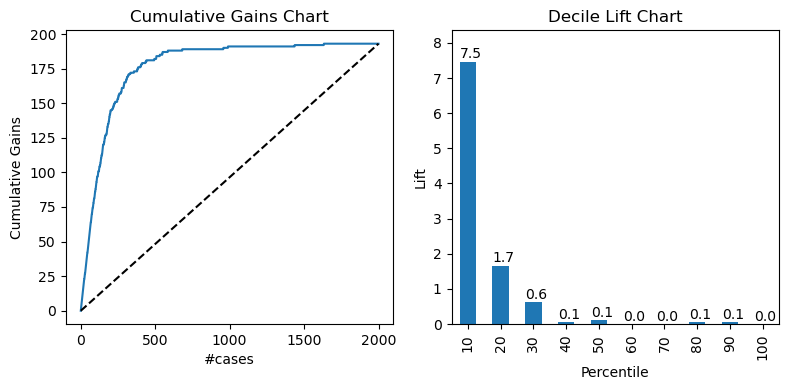

In [21]:
proba = da_class.predict_proba(valid_X)
result = pd.DataFrame({'actual': valid_y,
                       'p(0)':  [p[0] for p in proba],
                       'p(1)':  [p[1] for p in proba],
                       'predicted': da_class.predict(valid_X) })
result = result.sort_values(by=['p(1)'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = gainsChart(result.actual, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_xlabel('#cases')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(result.actual, ax=axes[1], labelBars=True)

plt.tight_layout()
plt.show()

In [23]:
print(train_y.value_counts())

print('probability of accepting the loan', 287 / (287 + 2713))
print('expected profitability', 96 * 50 - 1000)

Personal Loan
0    2713
1     287
Name: count, dtype: int64
probability of accepting the loan 0.09566666666666666
expected profitability 3800
